
# Using Intel Geti SDK:

## Data ingestion, Retraining, Exporting Model, Testing Deployment

The Intel® Geti™ SDK is a python package which contains tools to interact with an Intel® Geti™ server via the REST API. It provides functionality for:

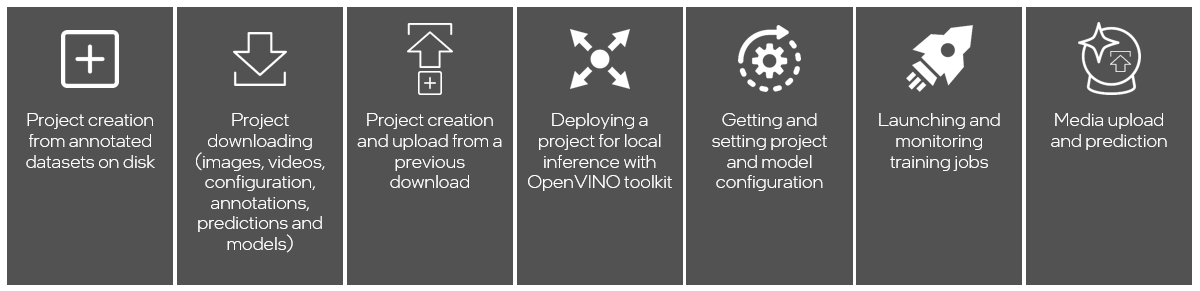

https://github.com/openvinotoolkit/geti-sdk
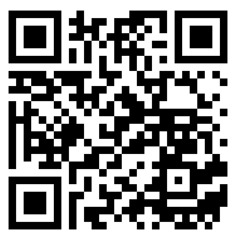

Once you have your model ready, you can download it via GUI or REST API to your model manager, then you can run process such as analytics and inference. Running the inference in OpenVINO will provide optimal performance.
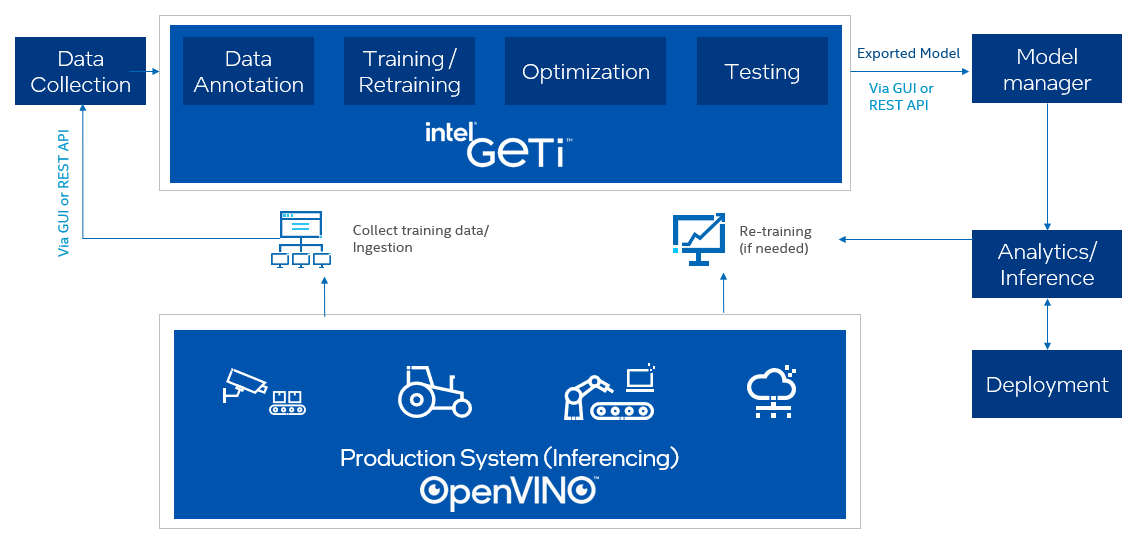

# How to ingest new production data into the Intel Geti platform?

What happens if something new comes in your production system? Different acquisition conditions, lighting, camera, backgrounds. You can connect your production system with Intel Geti Platform in a flexible way through the Intel Geti SDK.

### Connect with your Intel Geti Instance

We will connect to the platform first, using the server details from the .env file. We will also create a ProjectClient for the server.

In [1]:
# As usual we will connect to the platform first, using the server details from the .env file. We will also create a ProjectClient for the server

from geti_sdk import Geti
from geti_sdk.rest_clients import ProjectClient
from geti_sdk.utils import get_server_details_from_env

geti_server_configuration = get_server_details_from_env()

geti = Geti(server_config=geti_server_configuration)

project_client = ProjectClient(session=geti.session, workspace_id=geti.workspace_id)

C:\Intel\GitHub\geti-sdk\geti_sdk\http_session\geti_session.py:71: InsecureRequestWarning: You have disabled TLS certificate validation, HTTPS requests made to the Intel® Geti™ server may be compromised. For optimal security, please enable certificate validation.
  warnings.warn(


2022-12-22 13:01:58,524 - INFO - Personal access token validated on host https://10.91.120.185


### Setting up the project client, video client and prediction client
In this notebook, we will need three client objects: A ProjectClient to retrieve the project we want to upload to, an VideoClient to be able to upload the video and a PredictionClient to request and receive the prediction for every video frame. We first set up the ProjectClient, since we will need to get the project we are interested in before we can initialize the other two clients.

In [2]:
from geti_sdk.rest_clients import PredictionClient, ProjectClient, VideoClient

project_client = ProjectClient(session=geti.session, workspace_id=geti.workspace_id)

Now that the project client is set up, we need to specify the project we would like to upload to. We will use the `bolt_detection` demo

In [3]:
projects = project_client.list_projects()

8 projects were found on the platform:

 Project: bolt_detection
  Task 1: Detection task
    Labels: ['good', 'bad', 'No Object']


 Project: AMR Detection in Warehouse - trained
  Task 1: Detection task
    Labels: ['AMR', 'No Object']


 Project: AMR Detection in Warehouse - untrained
  Task 1: Detection task
    Labels: ['AMR', 'No Object']


 Project: Bolts Anomaly Segmentation
  Task 1: Anomaly segmentation task
    Labels: ['Normal', 'Anomalous']


 Project: Weed Det-Class upload
  Task 1: Detection task
    Labels: ['pot', 'No Object']
  Task 2: Classification task
    Labels: ['broadleaf', 'grass', 'clover']


 Project: Counting coffee fruits
  Task 1: Instance segmentation task
    Labels: ['Immature', 'Semi-mature', 'Mature', 'Overmature', 'Empty']


 Project: Counting coffee fruits - trained
  Task 1: Instance segmentation task
    Labels: ['Immature', 'Semi-mature', 'Mature', 'Overmature', 'Empty']


 Project: Weeds Pot2Class
  Task 1: Detection task
    Labels: ['pot', 'N

In [ ]:
PROJECT_NAME = "bolt_detection"

With the project name specified, we can retrieve the project details from the project client and use the returned `Project` object to set up an `video_client` and `prediction_client` for this project.

In [ ]:
project = project_client.get_project_by_name(PROJECT_NAME)
video_client = VideoClient(
    session=geti.session, workspace_id=geti.workspace_id, project=project
)

prediction_client = PredictionClient(
    session=geti.session, workspace_id=geti.workspace_id, project=project
)


## Uploading an video
The SDK contains an example video that we can grab and upload to the project. The path to the video is in the `EXAMPLE_VIDEO_PATH` constant, from the `geti_sdk.demos` module. We can upload the video directly from file using the `image_client.upload_video()` method. Before uploading, we can get a list of all videos in the project, so that we can verify that the image was uploaded successfully

In [ ]:
videos = video_client.get_all_videos()
print(f"Project '{project.name}' contains {len(videos)} videos.")

Now, we will upload the example image from the SDK. Of course, you can replace the `EXAMPLE_IMAGE_PATH` with a path to one of your own images as well.

In [ ]:
VIDEO_PATH = "C:/Users/paularam/OneDrive - Intel Corporation/SC_Docs/Demos/e2e_demos_documentation/bolts_videos/abnormal_10ms.mp4"

#from geti_sdk.demos import VIDEO_PATH
video = video_client.upload_video(video=VIDEO_PATH)

Let's fetch the list of images again and see if it has changed

In [ ]:
videos = video_client.get_all_videos()
print(f"Project '{project.name}' contains {len(videos)} videos.")

## Go to the GUI to see/edit the annotations
Once you upload the new production data, you should open the GUI and check, approve or edit the annotations. When the model is ready you can download the deployment and run it locally or run the inference in the platform. In this example we will download the deployment and run it locally.

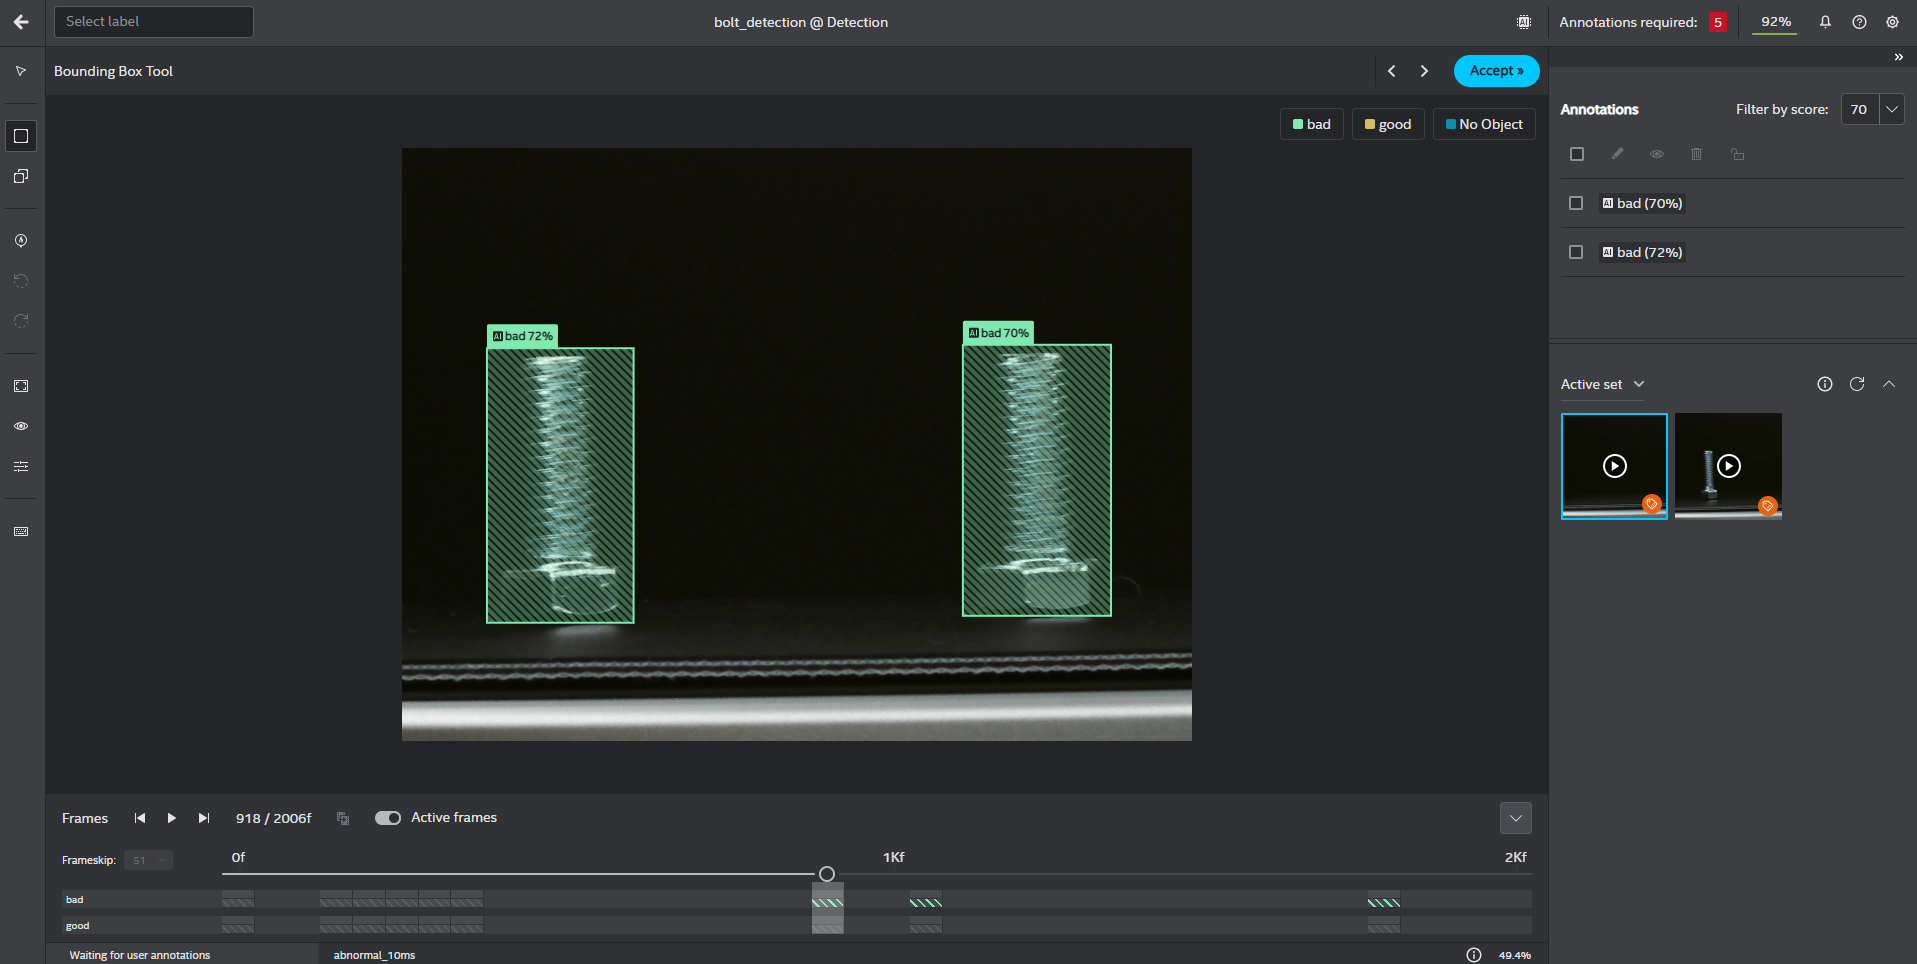

## Download the model and run the deployment locally
Before deploying, we need to make sure that the project is trained. Otherwise it will not contain any models to deploy, and the deployment will fail.

In [ ]:
from geti_sdk.demos import ensure_trained_example_project

ensure_trained_example_project(geti=geti, project_name=PROJECT_NAME);

Once we are sure that the project has trained models for each task, we can create the deployment in the cell below.

In [ ]:
deployment = geti.deploy_project(project_name=PROJECT_NAME)

## Saving the deployment
When we create the deployment, the model data is saved to a temporary folder. We store the deployment for offline re-use later on by saving it: This will copy the model data from the temporary folder to the path we specify. If we want to run inference locally again, we can simply reload the deployment from the saved folder, without having to connect to the platform again.

In [ ]:
import os

PATH_TO_DEPLOYMENT_FOLDER = os.path.join("deployments", PROJECT_NAME)

deployment.save(path_to_folder=PATH_TO_DEPLOYMENT_FOLDER)

# How to run the inference using the Intel Geti Model

You can try your model runing the demo.py file that you will find in the Deployment folder, in this case: ``C:\Intel\GitHub\geti-sdk\notebooks\deployments\bolt_detection\deployment\Detection task\python``

But in this notebook we will see how we can run the inference locally and send bad detection frames to the Intel geti Platfomr, in order to annotate those again and retrain a new model.

In [ ]:
# As usual we will connect to the platform first, using the server details from the .env file. We will also create a ProjectClient for the server

from geti_sdk import Geti
from geti_sdk.rest_clients import ProjectClient
from geti_sdk.utils import get_server_details_from_env

geti_server_configuration = get_server_details_from_env()

geti = Geti(server_config=geti_server_configuration)

project_client = ProjectClient(session=geti.session, workspace_id=geti.workspace_id)

### Packages and dependencies for running the inference using the Intel Geti SDK

The Intel Geti SDK is using OTE (OpenVINO training extensions) and OpenVINO Model API for running the inference. In the next cell you will see the requirements for that.

In [ ]:
from re import T
import sys
from pathlib import Path
from tkinter import N
from tracemalloc import start
from turtle import speed
import os

if os.name == 'nt':
    import msvcrt

from cv2 import FONT_HERSHEY_COMPLEX
import cv2
import time
import numpy as np
import copy
from typing import Union
from datetime import datetime
from ote_sdk.usecases.exportable_code.demo.demo_package.model_container import (
    ModelContainer,
)
from ote_sdk.usecases.exportable_code.demo.demo_package.utils import (
    create_output_converter,
)
from ote_sdk.usecases.exportable_code.demo.demo_package import (
    create_visualizer
)
from openvino.model_zoo.model_api.adapters import (
    OpenvinoAdapter, create_core
)
from geti_sdk.rest_clients import ImageClient, PredictionClient, ProjectClient

project_client = ProjectClient(session=geti.session, workspace_id=geti.workspace_id)

project = project_client.get_project_by_name(PROJECT_NAME)
image_client = ImageClient(
    session=geti.session, workspace_id=geti.workspace_id, project=project
)



### Preparing the inference setup

We will use the downloaded model previously, but you can ping a different path if you already have that model in another folder or if you download the model using the GUI.

In [ ]:
#inference setup
#============================================
deployments_path = "C:/Intel/GitHub/geti-sdk/notebooks/deployments"
project_name = 'bolt_detection'
CV_Task = 'Detection task'


### OpenVINO training extensions and OpenVINO Model API

We will use OTE to initialize the model, visualize the labels and convert the model output.

Note: This process is agnostic to the Computer Vision Task and Model Architecture. So, that means, that independely of model or task type this process will work for reading the input tensor to the models and for interpreting its output.

In [ ]:
from pathlib import Path
import sys
model_dir = Path(f"{deployments_path}/{project_name}/deployment/{CV_Task}/model")
sys.path.append(f"{deployments_path}/{project_name}/deployment/{CV_Task}/python")

## ==========================Using Exportable code========================
model = ModelContainer(model_dir)
visualizer = create_visualizer(model.task_type)
converter = create_output_converter(model.task_type, model.labels)
model_adapter = OpenvinoAdapter(create_core(), model_dir/"model.xml", device ="CPU")
print(model.task_type)
print(model.labels)
print(model_adapter.device)

### Main function for running the inference with video files or USB camera

This main function create a video player object to manage video files or USB cameras. By default we split the video in 30 FPS, and every single frame will be analized by the model. 

In [ ]:
# Main processing function to run object detection.
def run_object_detection(source=0, flip=False, use_popup=False, skip_first_frames=0):
    player = None
    try:
        # Create a video player to play with target fps.
        player = utils.VideoPlayer(
            source=source, flip=flip, fps=30, skip_first_frames=skip_first_frames
        )
        # Start capturing.
        player.start()
        if use_popup:
            title = "Press ESC to Exit"
            cv2.namedWindow(
                winname=title, flags=cv2.WINDOW_GUI_NORMAL | cv2.WINDOW_AUTOSIZE
            )

        processing_times = collections.deque()
        while True:
            # Grab the frame.
            frame = player.next()
            if frame is None:
                print("Source ended")
                break
            # If the frame is larger than full HD, reduce size to improve the performance.
            scale = 1280 / max(frame.shape)
            if scale < 1:
                frame = cv2.resize(
                    src=frame,
                    dsize=None,
                    fx=scale,
                    fy=scale,
                    interpolation=cv2.INTER_AREA,
                )
            input_image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) 
            
            # Measure processing time.

            start_time = time.time()
            
            ## ==========================Using OTE predictions========================
            # Get the results.
            predictions, frame_meta = model(input_image)
            print(predictions)
            
            stop_time = time.time()
            processing_times.append(stop_time - start_time)
            
            ### if the prediction is empty send the image to Intel Geti
            if len(predictions) == 1:
                image = image_client.upload_image(frame)
            ## =======================================================================

            
            
            ## ==========================Using OTE annotations ========================
            # Get output from network results.
            annotation_scene = converter.convert_to_annotation(predictions, frame_meta)
            output = visualizer.draw(input_image, annotation_scene, frame_meta)
            ## =======================================================================
            
            # Use processing times from last 200 frames.
            if len(processing_times) > 200:
                processing_times.popleft()

            _, f_width = frame.shape[:2]
            # Mean processing time [ms].
            #processing_time = np.mean(processing_times) * 1000
            #fps = 1000 / processing_time
            #cv2.putText(
            #    img=output,
            #    text=f"Inference time: {processing_time:.1f}ms ({fps:.1f} FPS)",
            #    org=(20, 40),
            #    fontFace=cv2.FONT_HERSHEY_COMPLEX,
            #    fontScale=f_width / 1000,
            #    color=(0, 0, 255),
            #    thickness=1,
            #    lineType=cv2.LINE_AA,
            #)

            # Use this workaround if there is flickering.
            if use_popup:
                cv2.imshow(winname=title, mat=output)
                key = cv2.waitKey(1)
                # escape = 27
                if key == 27:
                    break
            else:
                # Encode numpy array to jpg.
                _, encoded_img = cv2.imencode(
                    ext=".jpg", img=output, params=[cv2.IMWRITE_JPEG_QUALITY, 100]
                )
                # Create an IPython image.
                i = display.Image(data=encoded_img)
                # Display the image in this notebook.
                display.clear_output(wait=True)
                display.display(i)
    # ctrl-c
    except KeyboardInterrupt:
        print("Interrupted")
    # any different error
    except RuntimeError as e:
        print(e)
    finally:
        if player is not None:
            # Stop capturing.
            player.stop()
        if use_popup:
            cv2.destroyAllWindows()

In [ ]:
from openvino.runtime import Core
import matplotlib
from PIL import Image
import numpy as np
import json
import cv2
import sys

import collections
import os
import time

from IPython import display

sys.path.append("./utils")
import notebook_utils as utils

#video_file = "C:/Users/paularam/OneDrive - Intel Corporation/Pictures/Camera Roll/WIN_20221024_08_18_26_Pro.mp4"
video_file = "C:/Users/paularam/OneDrive - Intel Corporation/SC_Docs/Demos/e2e_demos_documentation/bolts_videos/abnormal_10ms.mp4"
#video_file = "C:/Users/paularam/OneDrive - Intel Corporation/SC_Docs/Demos/e2e_demos_documentation/bolts_videos/mix_10ms.mp4"
run_object_detection(source=video_file, flip=False, use_popup=False)